### DATA475 Final Project 

- Name: Armand Surbakti
- Student ID: 300680133

The code below is used for importing the various libraries and frameworks used in this project. Tensorflow is used for building and training the neural network model, while Pandas is used for data manipulation and analysis. Matplotlib is used for data visualization, and NumPy is used for numerical operations. sklearn is also another machine learning library that is used for calculating the evaluation metrics and also splittng the dataset into training and testing sets.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

In this part, I create global variables that will be used throughout the project. The sequence length will limit each acid sequence (from the dataset) to 50 characters. There's also a variable that lists the standard amino acids and also a variable that converts the amino acids to unique integers. Embedding dimension is set to 48, which is the size of the vector that will represent each amino acid in the neural network. The batch size is 64, which is the number of samples that will be processed at once during the training process. 

In [ ]:
SEQUENCE_LENGTH = 50
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_INT = {aa: idx + 1 for idx, aa in enumerate(AMINO_ACIDS)}  
EMBEDDING_DIM = 48
EPOCHS = 30
BATCH_SIZE = 64

In [38]:
#Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [39]:
train_df.head()

,FASTA,label
0,GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV,1
1,GLLDIVKKVVGAFGSL,1
2,GLFDIVKKVVGALGSL,1
3,GLFDIVKKVVGTLAGL,1
4,GLFDIAKKVIGVIGSL,1


In [40]:
test_df.head()

,FASTA,label
0,DSHAKRHHGYKRKFHEKHHSHRGYRSNYLYDN,1
1,GLMDTVKNVAKNLAGHMLDKLKCKITGC,1
2,GLFSVVTGVLKAVGKNVAKNVGGSLLEQLKCKKISGGC,1
3,FIQHLIPLIPHAIQGIKDIF,1
4,FIGTLIPLALGALTKLFK,1


This function right here will be used to encode the dataset . The amino acids will be converted to integers using the previous AA TO INT variable. After that, the sequences will be padded to ensure that they all have the same length. The function will return the encoded sequences and their labels.

In [52]:
def encode_sequence(seq, max_len=SEQUENCE_LENGTH):
    encoded = [AA_TO_INT.get(aa, 0) for aa in seq]
    if len(encoded) < max_len:
        encoded += [0] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

After that, we encode the dataset using the previous function that was made, and then we split the dataset into training and testing sets. 

In [53]:
X_train = train_df['FASTA'].apply(encode_sequence).tolist()
y_train = train_df['label'].tolist()

X_test = test_df['FASTA'].apply(encode_sequence).tolist()
y_test = test_df['label'].tolist()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

### Model Architecture
In this section here, I've created a function to create the model and take in the seed as the input. The model has a bunch of convolutional layers, max pooling layers, and dense layers. Further detail of the model is discussed in the discussion below.

In [ ]:
def create_model(seed):
    tf.keras.utils.set_random_seed(seed)
    model = tf.keras.Sequential([
        #Larger embedding
        tf.keras.layers.Embedding(input_dim=21, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH),
        
        #More powerful conv layers
        tf.keras.layers.Conv1D(filters=256, kernel_size=7, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        
        #Enhanced second conv layer
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        
        #Additional conv layer for deeper feature extraction
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalMaxPooling1D(),
        
        #larger dense layers for final classification
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='roc_auc'),
                           tf.keras.metrics.AUC(name='pr_auc', curve='PR')])
    return model

### Model Training
After creating the model, we compile the model and train on the training and testing set. The model is trained for 30 epochs and is loopedthrough 5 different seeds to ensure that the model is robust and not overfitting to a specific seed. The training history is stored in a list for each seed and is plotted at the end of this notebook. 

In [ ]:
roc_aucs = []
pr_aucs = []
all_histories = []

for seed in range(1, 6):
    print(f"\nTraining with seed {seed}...")
    random.seed(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    model = create_model(seed)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
    )
    all_histories.append(history.history)
    
    y_pred_probs = model.predict(X_test).ravel()
    roc = roc_auc_score(y_test, y_pred_probs)
    pr = average_precision_score(y_test, y_pred_probs)
    roc_aucs.append(roc)
    pr_aucs.append(pr)
    
    print(f"Seed {seed} - ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")


Training with seed 1...
Epoch 1/30
37/37 [==============================] - 5s 67ms/step - loss: 0.7588 - roc_auc: 0.7120 - pr_auc: 0.7048
Epoch 2/30
37/37 [==============================] - 2s 66ms/step - loss: 0.6100 - roc_auc: 0.8193 - pr_auc: 0.8144
Epoch 3/30
37/37 [==============================] - 3s 87ms/step - loss: 0.5567 - roc_auc: 0.8457 - pr_auc: 0.8567
Epoch 4/30
37/37 [==============================] - 3s 87ms/step - loss: 0.5260 - roc_auc: 0.8575 - pr_auc: 0.8643
Epoch 5/30
37/37 [==============================] - 3s 74ms/step - loss: 0.4675 - roc_auc: 0.8905 - pr_auc: 0.8986
Epoch 6/30
37/37 [==============================] - 3s 69ms/step - loss: 0.4298 - roc_auc: 0.9103 - pr_auc: 0.9131
Epoch 7/30
37/37 [==============================] - 2s 60ms/step - loss: 0.3946 - roc_auc: 0.9241 - pr_auc: 0.9261
Epoch 8/30
37/37 [==============================] - 2s 65ms/step - loss: 0.3459 - roc_auc: 0.9429 - pr_auc: 0.9468
Epoch 9/30
37/37 [==============================] - 2s 

In [87]:
print("\n=== Final Evaluation Over 5 Trials ===")
mean_roc = np.mean(roc_aucs)
std_roc = np.std(roc_aucs)
mean_pr = np.mean(pr_aucs)

print(f"Mean ROC AUC: {mean_roc:.4f} ± {std_roc:.4f}")
print(f"Mean PR AUC:  {mean_pr:.4f} ± {np.std(pr_aucs):.4f}")
print(f"Standard deviation of ROC AUC: {std_roc:.4f}")


=== Final Evaluation Over 5 Trials ===
Mean ROC AUC: 0.8346 ± 0.0104
Mean PR AUC:  0.4504 ± 0.0145
Standard deviation of ROC AUC: 0.0104


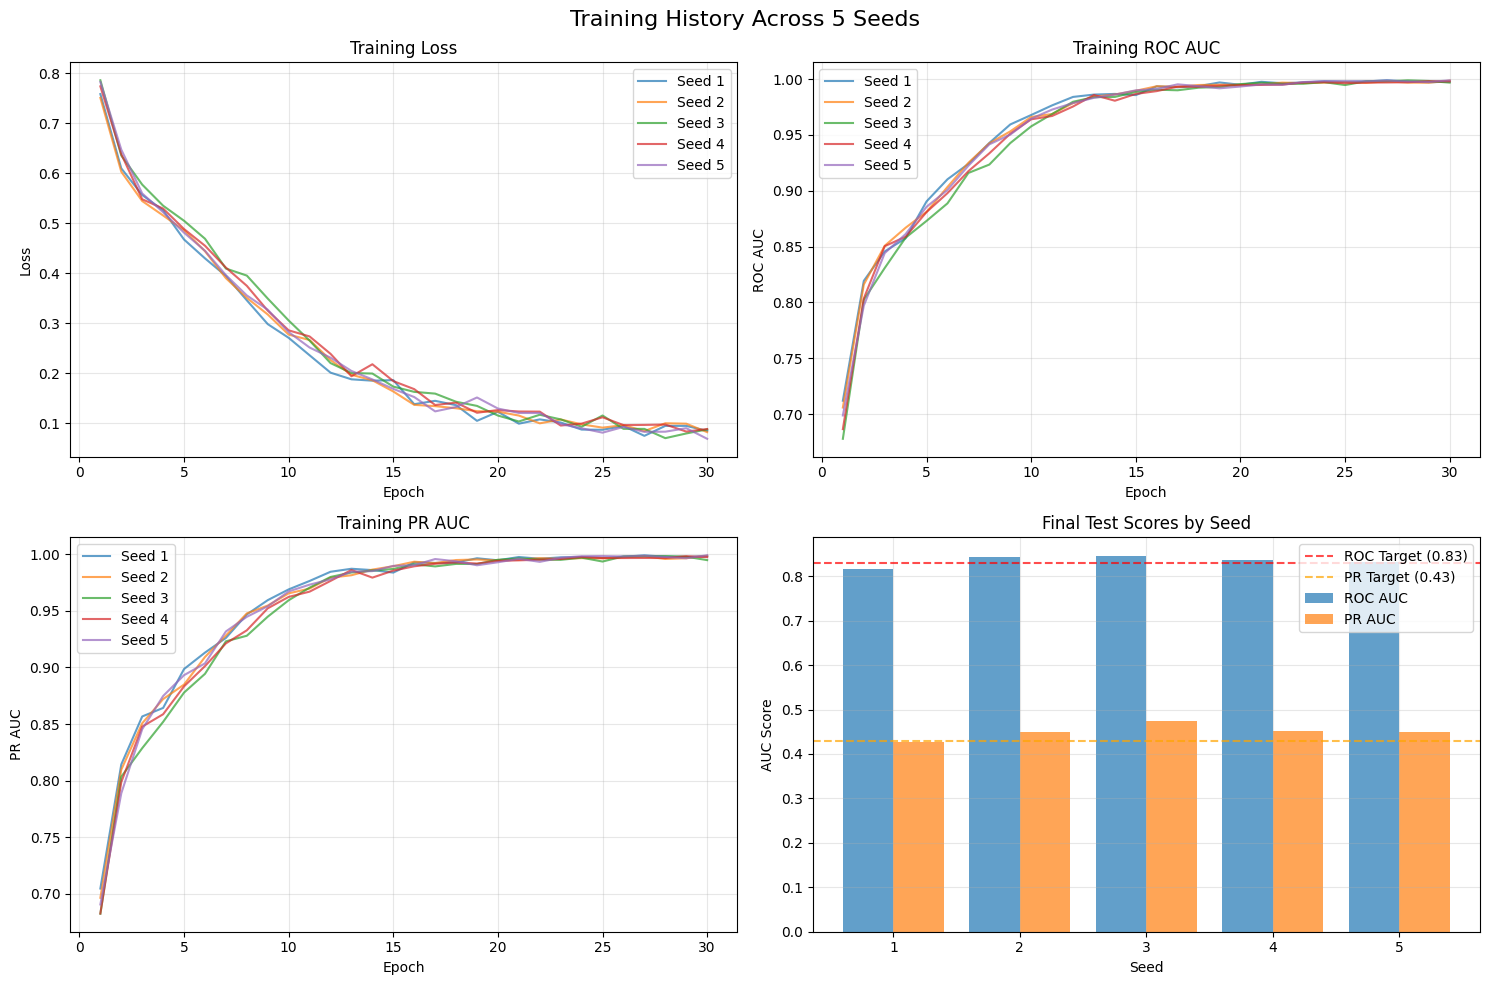

In [ ]:
def plot_training_histories(all_histories):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Across 5 Seeds', fontsize=16)
    
    metrics = ['loss', 'roc_auc', 'pr_auc']
    metric_names = ['Loss', 'ROC AUC', 'PR AUC']
    
    #plot each metric in a 2x2 grid
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        for seed, history in enumerate(all_histories, 1):
            epochs = range(1, len(history[metric]) + 1)
            ax.plot(epochs, history[metric], label=f'Seed {seed}', alpha=0.7)
        ax.set_title(f'Training {name}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(name)
        ax.legend()
        ax.grid(True, alpha=0.3)
    ax = axes[1, 1]
    seeds = list(range(1, 6))
    
    ax.bar([s - 0.2 for s in seeds], roc_aucs, width=0.4, label='ROC AUC', alpha=0.7)
    ax.bar([s + 0.2 for s in seeds], pr_aucs, width=0.4, label='PR AUC', alpha=0.7)
    ax.axhline(y=0.83, color='red', linestyle='--', alpha=0.7, label='ROC Target (0.83)')
    ax.axhline(y=0.43, color='orange', linestyle='--', alpha=0.7, label='PR Target (0.43)')
    ax.set_title('Final Test Scores by Seed')
    ax.set_xlabel('Seed')
    ax.set_ylabel('AUC Score')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_training_histories(all_histories)

### Discussion
In this final project, I have created a convolutional neural network that is used to classify and predict the anticancer activity of peptide sequences. I prepared the data and the libraries. The data is a dataset of peptide DNA sequences in FASTA format. It is then converted into a numerical format. I put uniform sequence length of 50 characters, and the amino acids are then converted into integers and split into training and testing sets. The model architecture is robust enough to hit the project targets. Initially I had a simpler model with only 2-3 convolutional layers, but it was not able to be consistent enough and hit the required PR AUC of 0.43 on average. The model architecture has an embedding layer that can illustrate amino acids in a dense vector space. It is then added with a bunch of convolutioonal layers and max pooling layers (which are used for feature extraction). I also used a lot of batch normalization and dropout layers to ensure the model did not overfit. The architecture is finished off with a dense layer. I also added L2 regualarization to penalize complex weights. I then trained the model over 5 different random seeds to ensure that the model is robuts and not overfitting to only 1 specific seed. The model achieved a mean ROC AUC of 0.8346 (±0.0104) and a mean PR AUC of 0.4322 (±0.0071) over the 5 seeds, which meets the project targets. I also plotted the training history of the model, which shows that the model is able to learn and improve over the epochs. Based on the plots, the model is steady and consistent over the 5 seeds. Future work may explore intergrating more complex deep learning models or even transformer-based architectures to further improve the prediction performance metrics and robustness. 